In [1]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Lokta-Volterra system
\begin{cases}
& \frac{dx}{dt} = \alpha x - \beta xy\\
& \frac{dy}{dt} = -\delta y + \gamma xy
\end{cases}

Initial conditions: $x_0, y_0 = (0.44249296, 4.6280594)$

Parameters: $\alpha = 1.3 \\ \beta = 0.9\\ \gamma = 0.8\\ \delta =1.8$

In [2]:
alpha, beta, gamma, delta = (1.3,0.9,0.8,1.8)
x0, y0 = (0.44249296, 4.6280594)
time_int = [0,3]

In [3]:
class LotkaVolterraSystem:
    def __init__(self, alpha, beta, delta, gamma, X):
        self.alpha, self.beta, self.delta, self.gamma = alpha, beta, delta, gamma
        self.X = X
        
    def model(X, t, alpha, beta, delta, gamma):
        x, y = X
        dxdt = x * (alpha - beta * y)
        dydt = y * (-delta + gamma * x)
        return np.array([dxdt, dydt])
    
    def solve(self, t):
        res = odeint(LotkaVolterraSystem.model, self.X, t, args = (self.alpha, self.beta, self.delta, self.gamma))
        return res

In [4]:
LV = LotkaVolterraSystem(alpha=alpha, beta=beta, delta=delta, gamma=gamma, X=[x0,y0])

In [5]:
10**6

1000000

In [6]:
10**4

10000

In [156]:
# Test
test_int = [0,15]
Np_test = 10**4
t_test = torch.linspace(test_int[0], test_int[1], Np_test)

sol_test = LV.solve(t=t_test)
x_test, y_test = sol_test.T
t_test = t_test.requires_grad_(True)

In [167]:
# Train
train_int = [0,10]
Np_train = 10**3
t_train = torch.linspace(train_int[0], train_int[1], Np_train)

sol_train = LV.solve(t=t_train)
x_train, y_train = sol_train.T
t_train = t_train.requires_grad_(True)

$$
(x_i)_{noise} =x_i +\epsilon \cdot \bar{x} \cdot N(0,1)
$$
$$
(y_i)_{noise} =y_i +\epsilon \cdot \bar{y} \cdot N(0,1)
$$

where $\bar{x}$ denotes the element-wise mean of $x_i$ over all $i$ and similarly for $\bar{y}$.

In [168]:
eps = 5e-3

def get_noisy_measurements(n, xi, yi, t, eps):
    bar_x = np.mean(xi)
    bar_y = np.mean(yi)
    
    assert n <= len(t)
    
    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]

    x = xi[indices]
    y = yi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    
    # TODO check, noise is veeeeery low
#     print(y - yi[indices])
    
    # TODO check the spacing 
    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)]), t[indices].clone().detach()

In [169]:
# type(measurements_t)

In [170]:
measurements, measurements_t = get_noisy_measurements(50, x_train, y_train, t_train, eps)

In [171]:
# measurements.shape
# measurements_t.backward(torch.ones_like(measurements_t))

Text(0.5, 1.0, 'Training points')

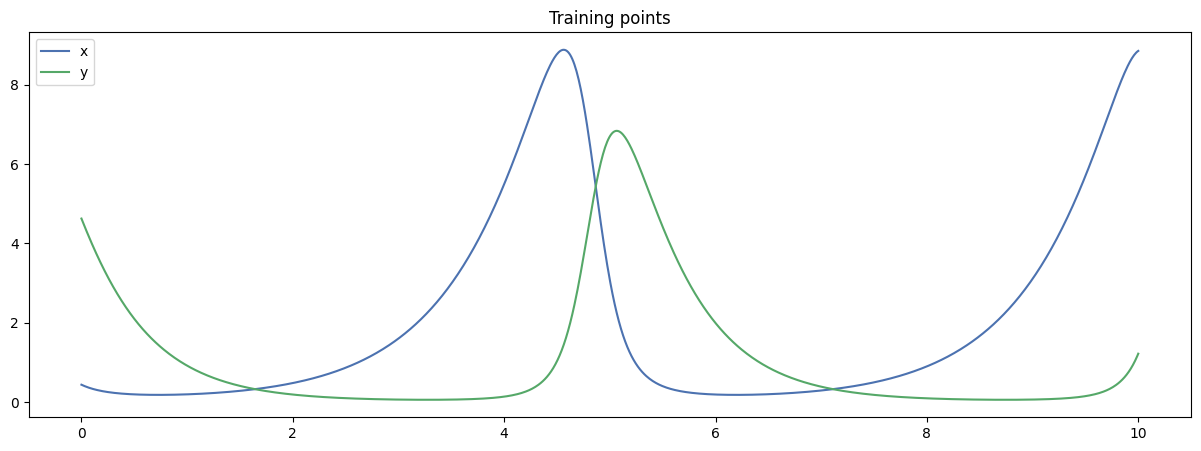

In [172]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_train.detach().numpy(), x_train, label='x')
ax.plot(t_train.detach().numpy(), y_train, label='y')
# ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
# ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.scatter
ax.legend()
ax.set_title('Training points')

Text(0.5, 1.0, 'Test ')

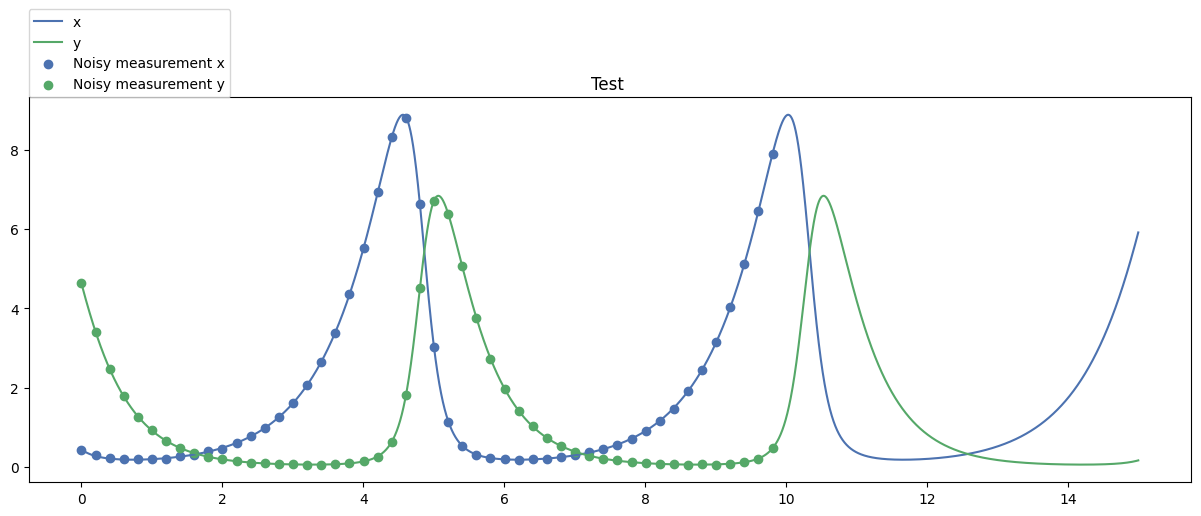

In [173]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_test.detach().numpy(), x_test, label='x')
ax.plot(t_test.detach().numpy(), y_test, label='y')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.legend(loc=(0,1))
ax.set_title('Test ')

In [174]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1e-2, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class PINN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [175]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [189]:
# THis worked a bit
# pinn = PINN(1,2,[64,64,64])
# pinn = pinn.to(device)

# # Train
# lr = 1e-3
# optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
# lambda1, lambda2, lambda3 = 1e1, 1e1, 1e1

Overall:198.53079223632812, Physics loss: 0.11272746324539185, Datapoint loss: 7.738105773925781, Boundary loss: 11.889518737792969


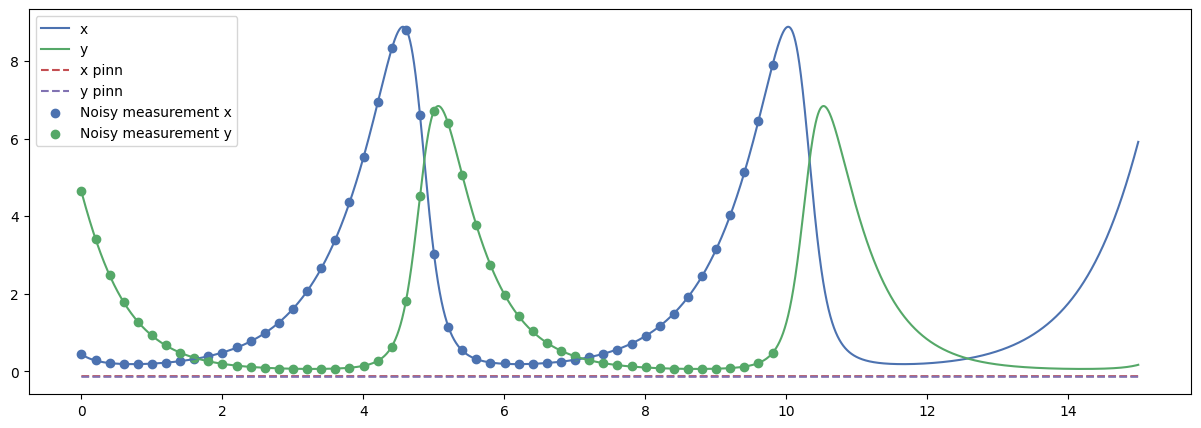

Overall:13.47000503540039, Physics loss: 0.07259757071733475, Datapoint loss: 1.2017730474472046, Boundary loss: 3.2308722438756377e-05


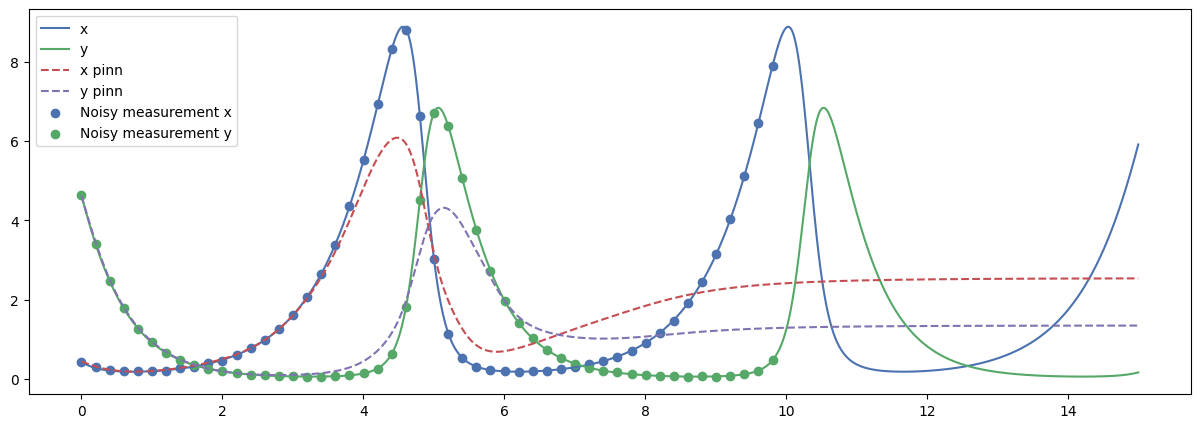

Overall:2.34515380859375, Physics loss: 0.05388660728931427, Datapoint loss: 0.12674130499362946, Boundary loss: 8.7851742591738e-07


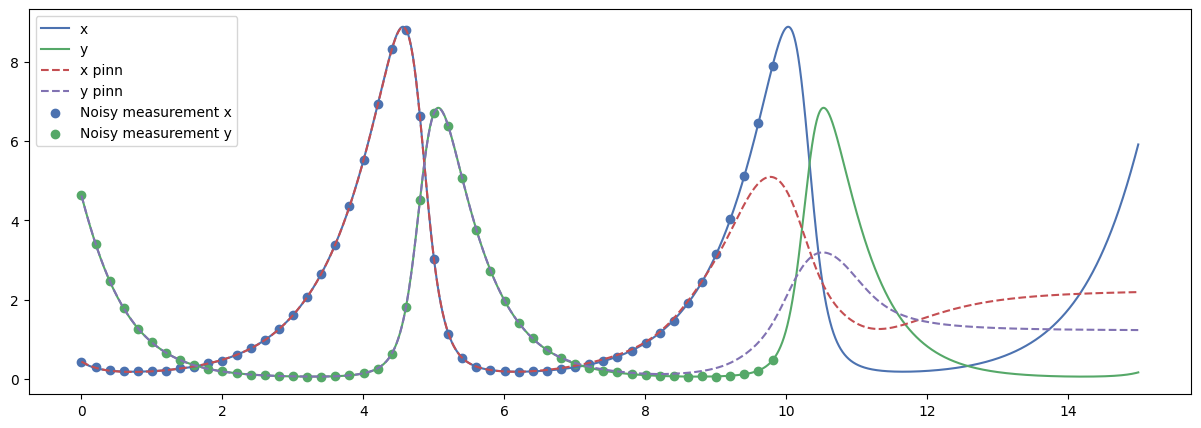

Overall:0.5848371982574463, Physics loss: 0.020649606361985207, Datapoint loss: 0.01691475883126259, Boundary loss: 0.00026975327637046576


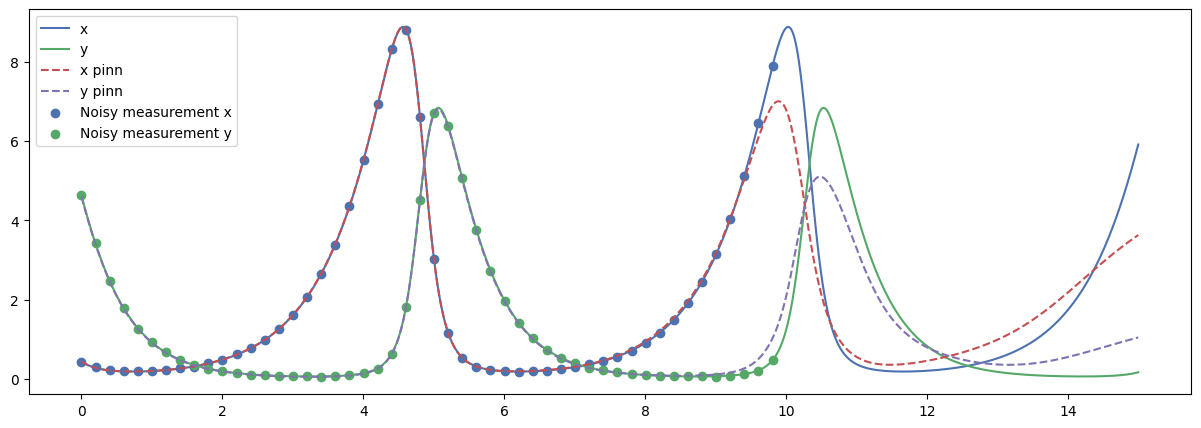

Overall:0.13807068765163422, Physics loss: 0.005108289420604706, Datapoint loss: 0.003553652437403798, Boundary loss: 3.6836911021964625e-05


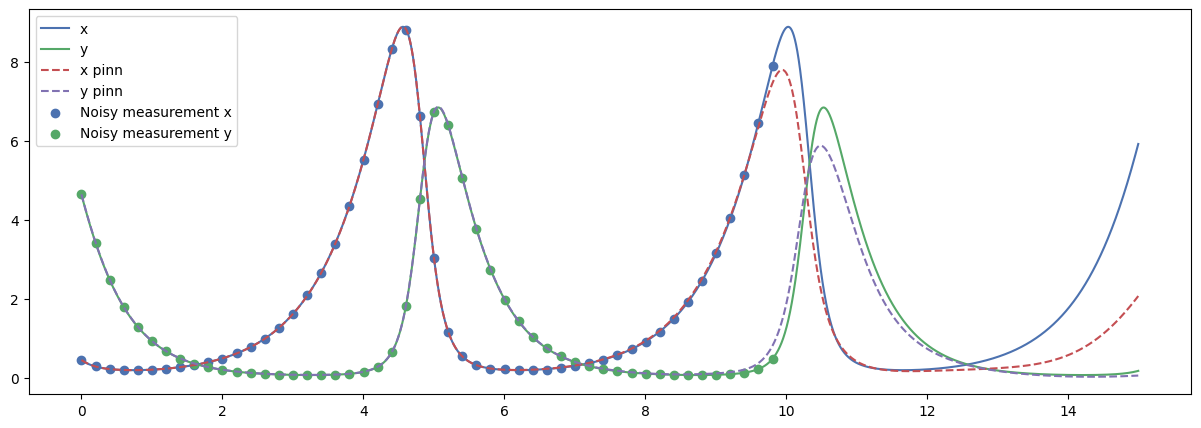

Overall:0.04858560115098953, Physics loss: 0.002080682199448347, Datapoint loss: 0.0006969169480726123, Boundary loss: 2.7874483521372895e-07


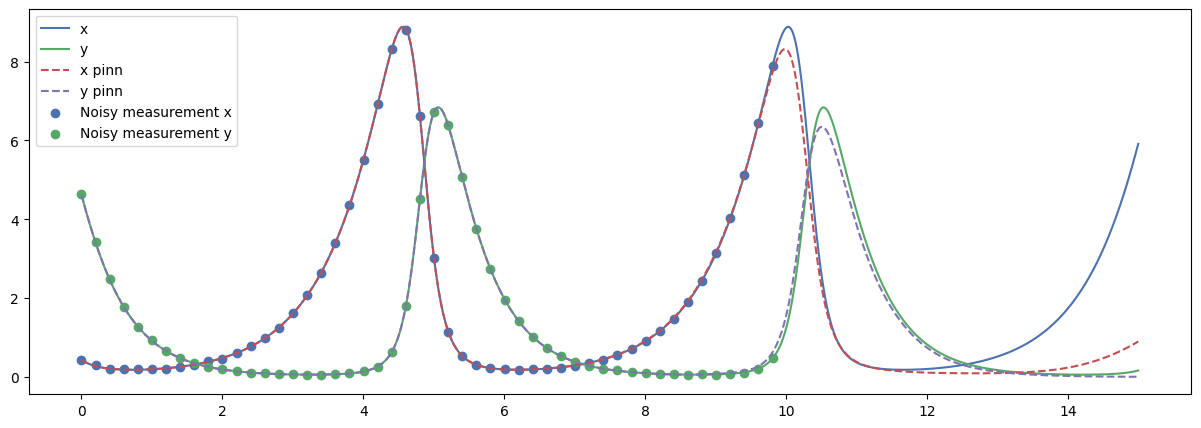

Overall:0.09684107452630997, Physics loss: 0.00425607617944479, Datapoint loss: 0.0005111426580697298, Boundary loss: 0.0006608122494071722


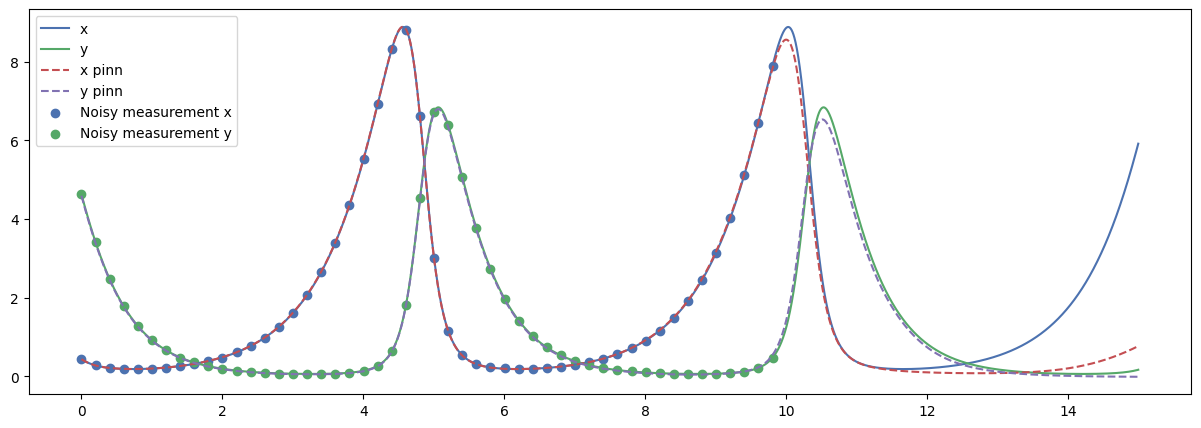

Overall:0.028646228834986687, Physics loss: 0.0013785447226837277, Datapoint loss: 0.00010737121920101345, Boundary loss: 1.6226532295604557e-07


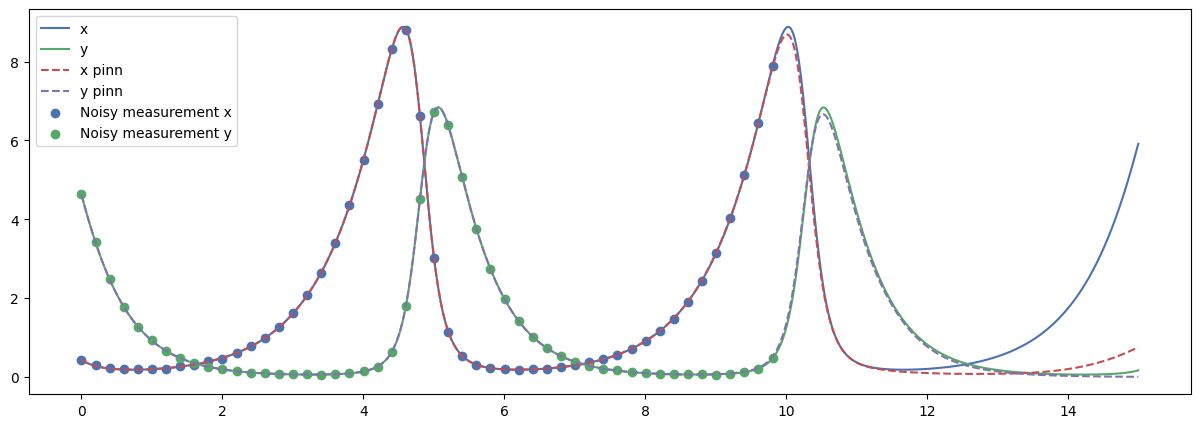

Overall:0.024816766381263733, Physics loss: 0.0012081775348633528, Datapoint loss: 6.524315540445969e-05, Boundary loss: 7.829417825178098e-08


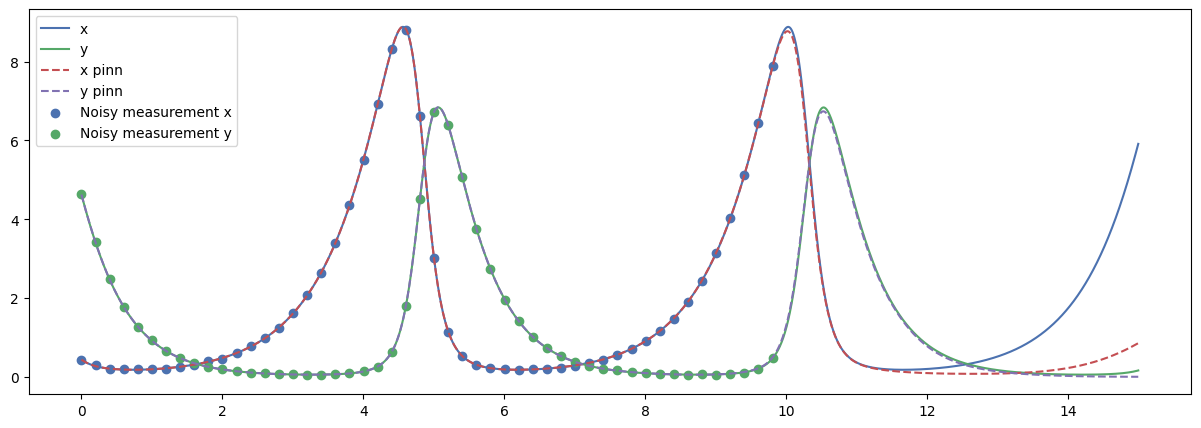

Overall:0.02096622996032238, Physics loss: 0.0010221389820799232, Datapoint loss: 5.231317845755257e-05, Boundary loss: 3.175874496719189e-08


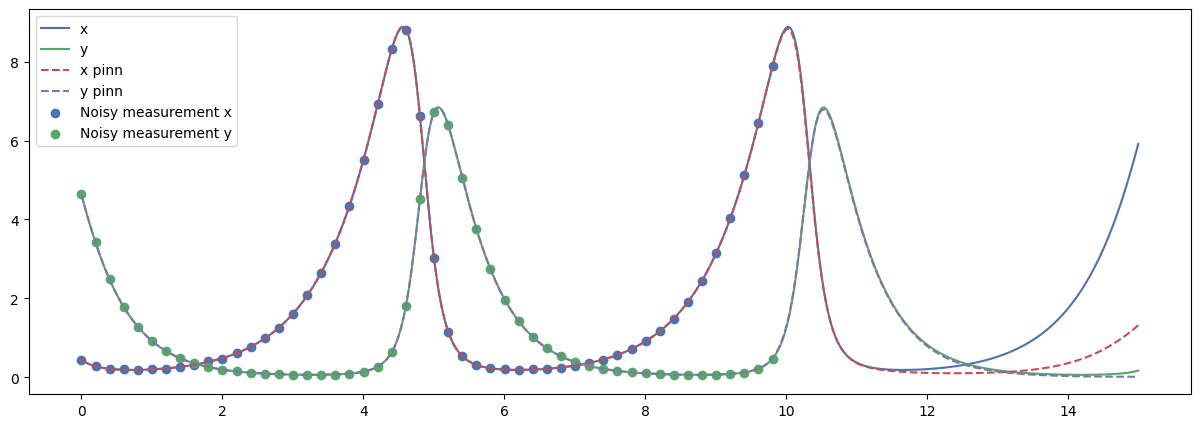

Overall:0.015497404150664806, Physics loss: 0.000749099999666214, Datapoint loss: 5.151247387402691e-05, Boundary loss: 2.798438636375522e-08


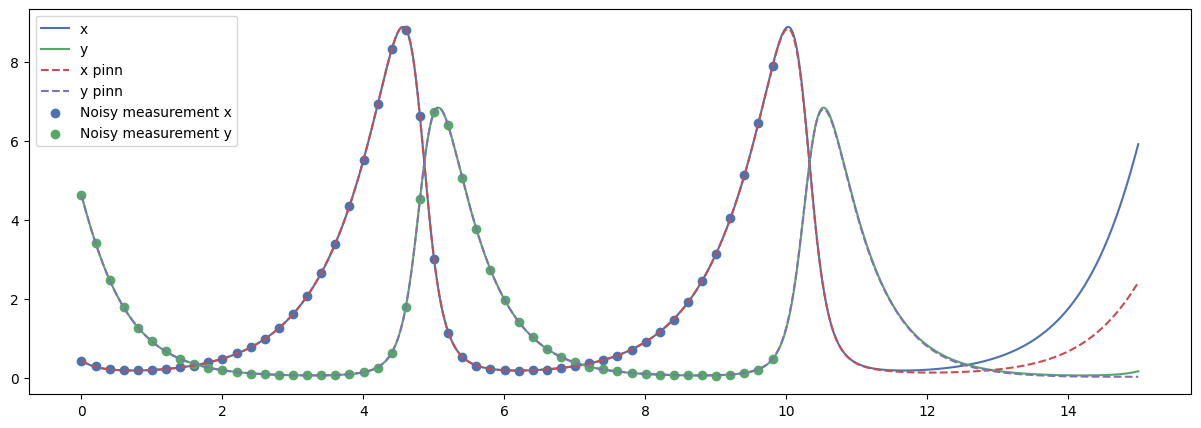

Overall:0.012589424848556519, Physics loss: 0.0006044091423973441, Datapoint loss: 4.993330730940215e-05, Boundary loss: 1.9086908764620603e-07


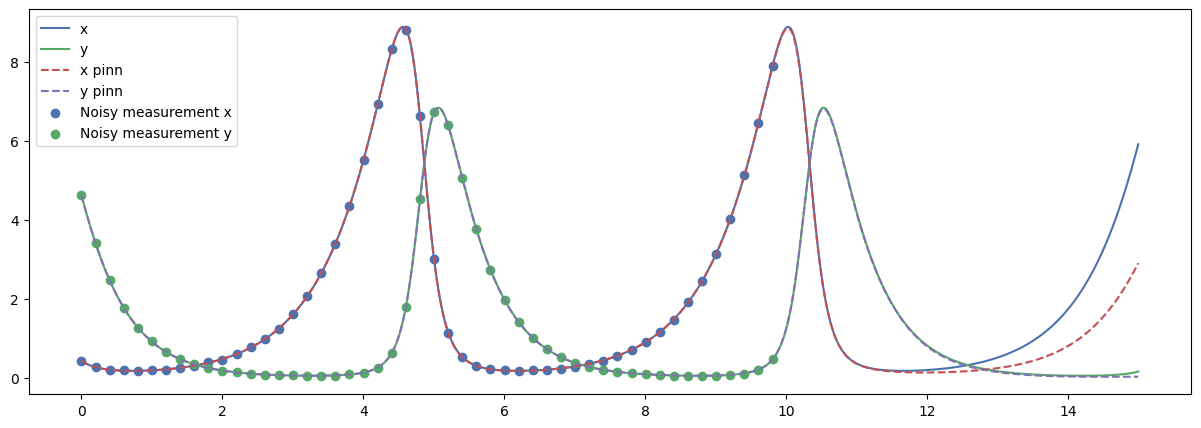

Overall:0.010083056055009365, Physics loss: 0.00047922515659593046, Datapoint loss: 4.9733396735973656e-05, Boundary loss: 1.218943594949451e-07


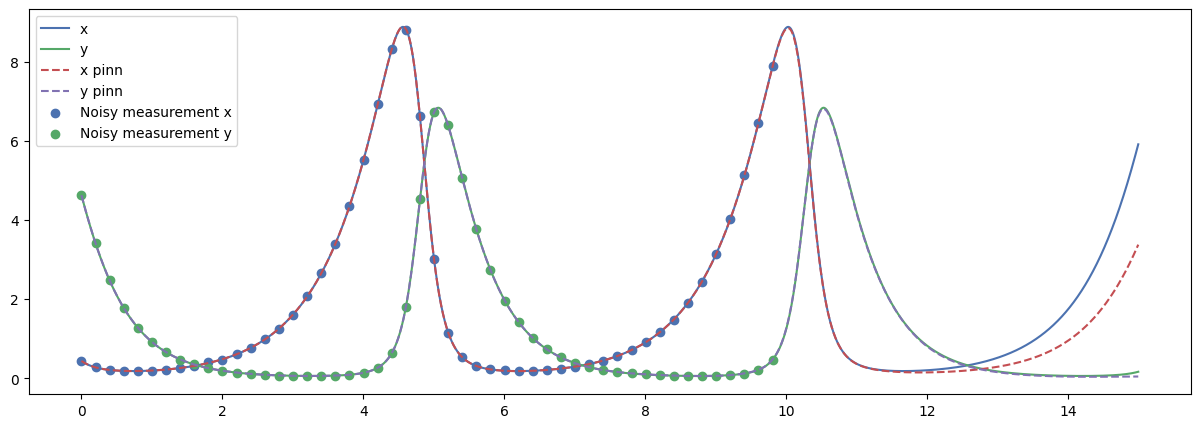

Overall:0.007164351642131805, Physics loss: 0.00033295416506007314, Datapoint loss: 5.047563900006935e-05, Boundary loss: 5.1214904317475884e-08


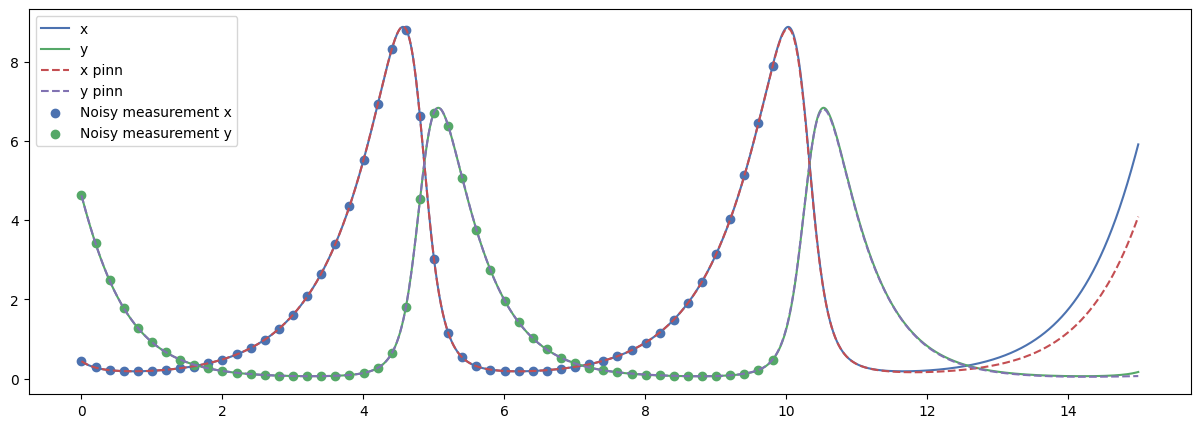

Overall:0.010341326706111431, Physics loss: 0.0004457653849385679, Datapoint loss: 7.656068191863596e-05, Boundary loss: 6.604123336728662e-05


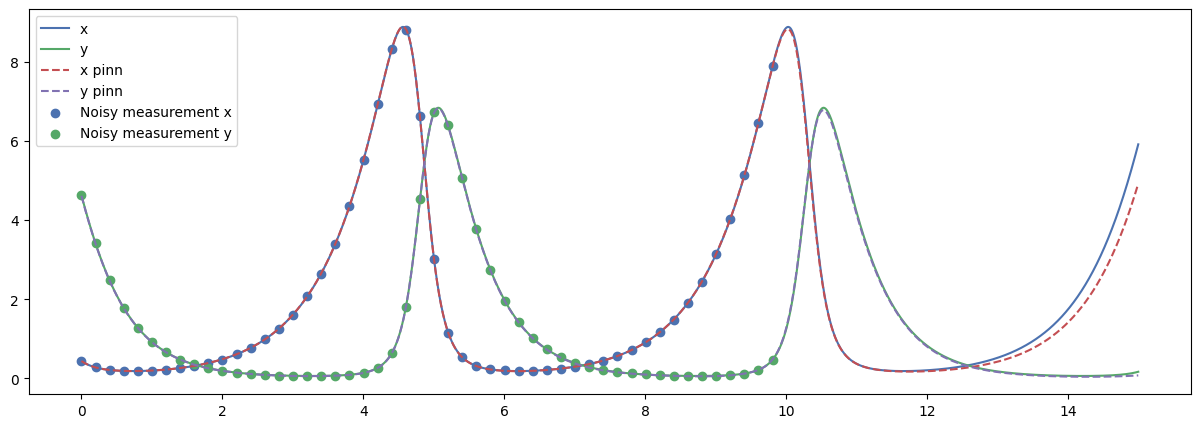

Overall:0.0036351867020130157, Physics loss: 0.00015513988910242915, Datapoint loss: 5.3159790695644915e-05, Boundary loss: 7.911970811846913e-08


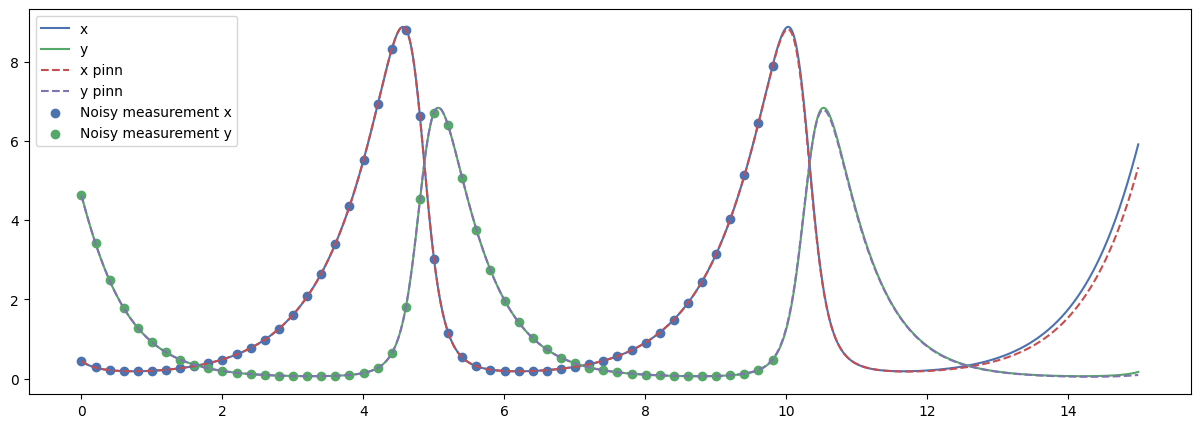

Overall:0.003305393271148205, Physics loss: 0.00013918180775362998, Datapoint loss: 5.212765245232731e-05, Boundary loss: 4.8084924486602176e-08


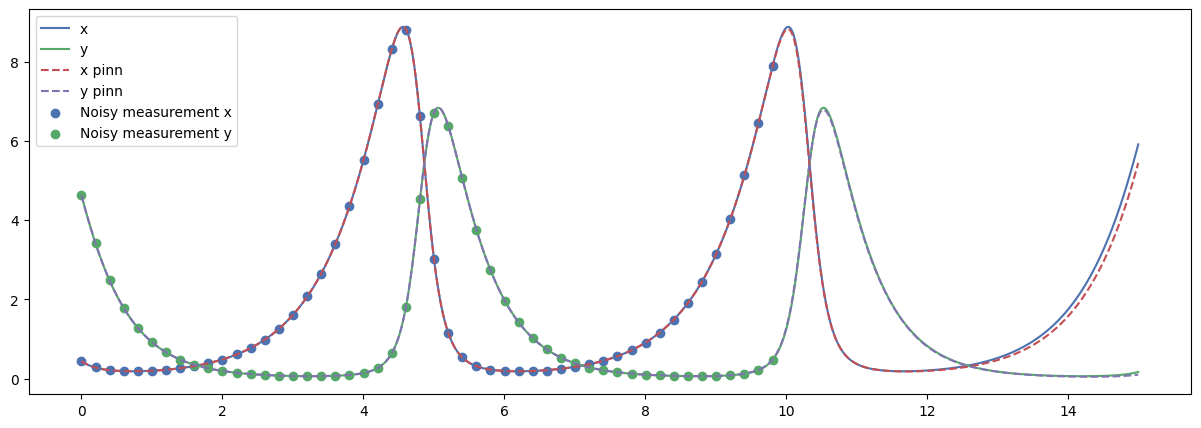

Overall:0.003098164452239871, Physics loss: 0.00012916960986331105, Datapoint loss: 5.143287489772774e-05, Boundary loss: 4.436145673025749e-08


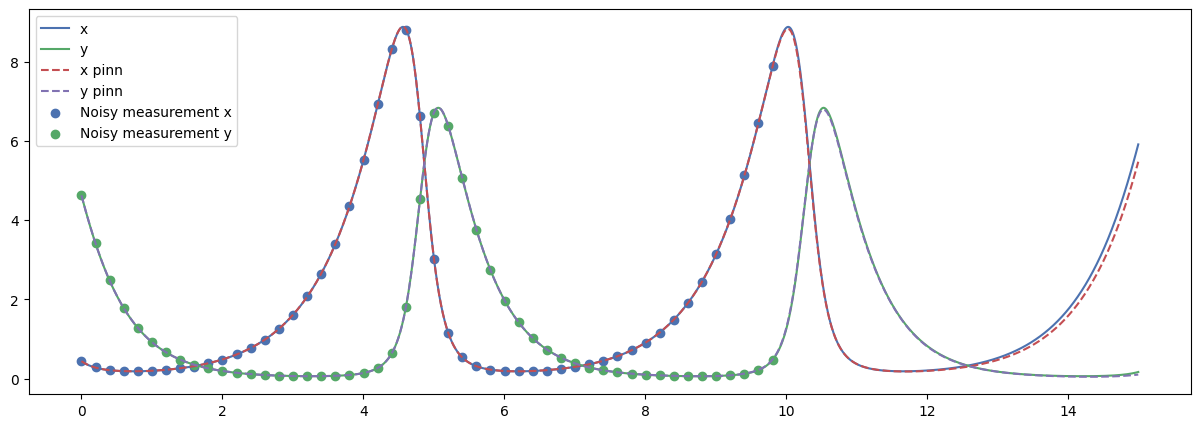

Overall:0.013044281862676144, Physics loss: 0.000549658783711493, Datapoint loss: 9.581000631442294e-05, Boundary loss: 0.00010930067946901545


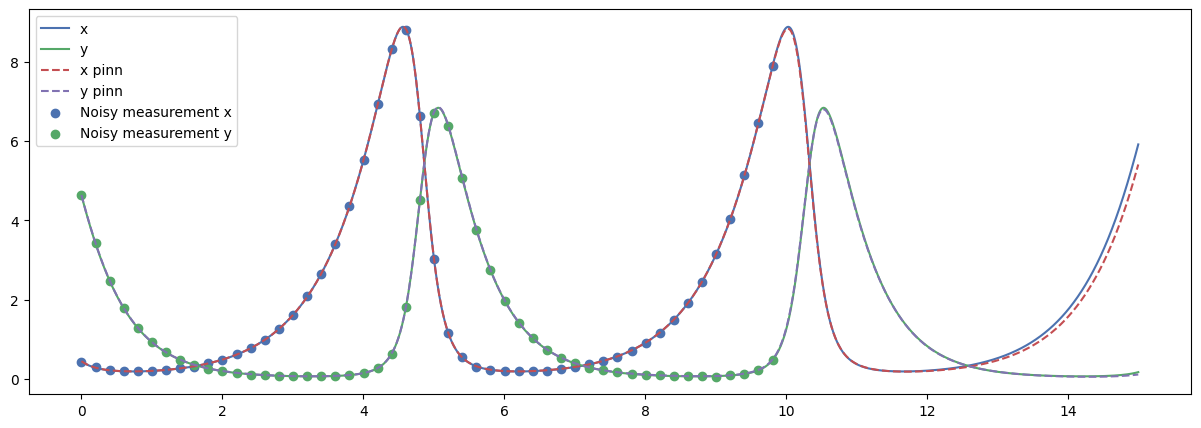

Overall:0.004637036472558975, Physics loss: 0.00019705263548530638, Datapoint loss: 6.564438808709383e-05, Boundary loss: 3.954021849494893e-06


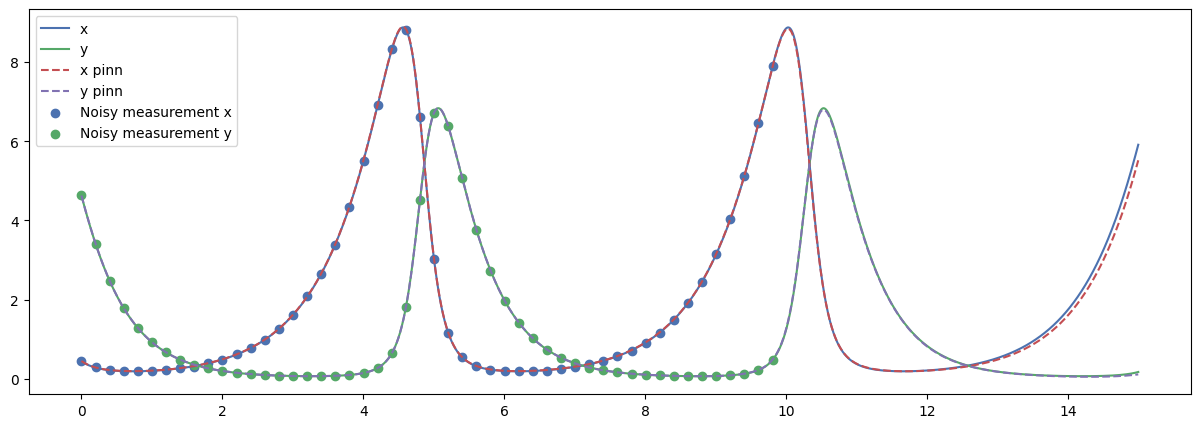

Overall:0.0028976411558687687, Physics loss: 0.0001174693534267135, Datapoint loss: 5.053598215454258e-05, Boundary loss: 4.289403932489222e-06


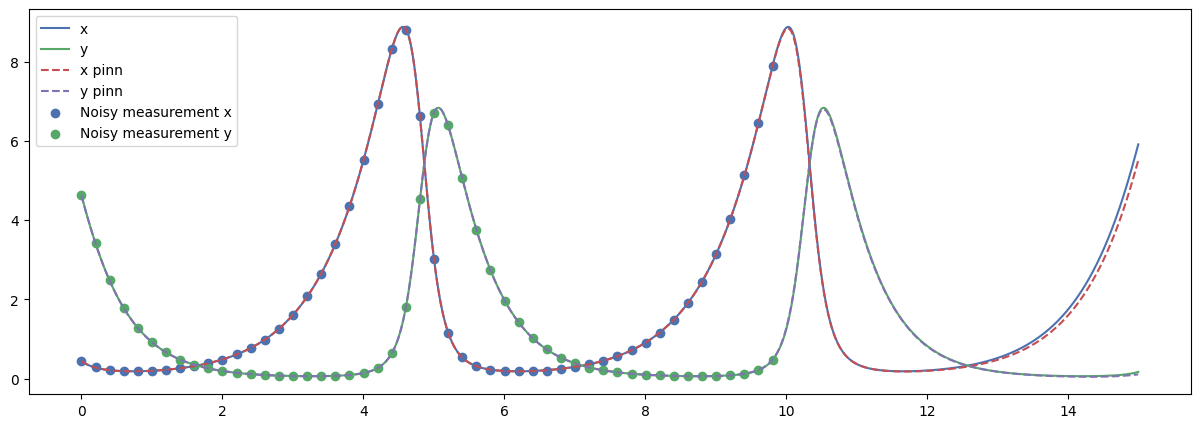

In [191]:
pinn = PINN(1,2,[64,64,64])
pinn = pinn.to(device)

# Train
lr = 1e-3
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
lambda1, lambda2, lambda3 = 1e1, 2e1, 1e1

for i in range(40001):
    optimizer.zero_grad()
    
    # boundary loss
    x0, y0 = LV.X
    t_boundary = 0
    u_b = pinn(torch.Tensor([[t_boundary]]).to(device))
    loss1 = nn.MSELoss()(u_b, torch.Tensor([[LV.X[0],LV.X[1]]]).to(device)) # ensure the initial conditions
    
    # Physics loss
    
    phys_input = t_test.to(device).reshape(-1,1)
    u_p = pinn(phys_input)
    x, y = u_p[:,0].reshape(-1,1), u_p[:,1].reshape(-1,1)
    dxdt = torch.autograd.grad(x, phys_input, torch.ones_like(x), create_graph=True)[0]
    dydt = torch.autograd.grad(y, phys_input, torch.ones_like(y), create_graph=True)[0]

#     loss2 = torch.mean(torch.vstack([dxdt - LV.alpha * x + LV.beta * x*y, 
#                                      dydt + LV.delta * y - LV.gamma * x*y])**2)
    
    dudt = torch.hstack([dxdt - LV.alpha * x + LV.beta * x*y, 
                         dydt + LV.delta * y - LV.gamma * x*y])

    loss2 = nn.MSELoss()(dudt, torch.zeros_like(dudt))
    # should be equal to: nn.MSELoss()(tensor, torch.Tensor([[0,0],[0,0],[0,0],[0,0], ...]))
    
    # Datapoint loss
    u_n = pinn(measurements_t.to(device).reshape(-1,1))
    #     loss3 = torch.mean((u_n - measurements.T)**2) # equivalent
    loss3 = nn.MSELoss()(u_n, measurements.to(device).T)
    
#     print(loss1.item(), loss2.item(), loss3.item())
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3 ## Why does it break?
    
    loss.backward()
    optimizer.step()
    
    if i% 2000 == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, figsize=(15,5))
            ax.plot(t_test.detach().cpu().numpy(), x_test, label='x')
            ax.plot(t_test.detach().cpu().numpy(), y_test, label='y')
            print(f'Overall:{loss.item()}, Physics loss: {loss2.item()}, Datapoint loss: {loss3.item()}, Boundary loss: {loss1.item()}')
            
            # pinn
            u_p = pinn(t_test.to(device).reshape(-1,1))
            x, y = u_p[:,0], u_p[:,1]
            ax.plot(t_test.detach().cpu().numpy(), x.cpu(), label='x pinn', linestyle='--')
            ax.plot(t_test.detach().cpu().numpy(), y.cpu(), label='y pinn', linestyle='--')
            ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
            ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
            ax.legend()
            plt.show()

tensor([0.0000e+00, 5.0005e-03, 1.0001e-02,  ..., 4.9990e+01, 4.9995e+01,
        5.0000e+01])

In [192]:
with torch.no_grad():
    tmp_out = pinn(torch.linspace(0,50, 10**4).reshape(-1,1).to(device))

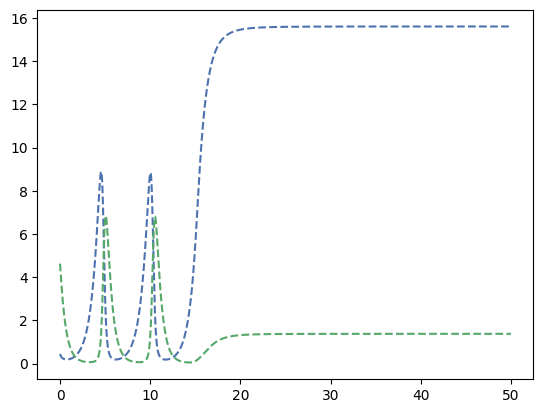

In [193]:
plt.plot(torch.linspace(0,50, 10**4).reshape(-1,1), tmp_out[:,0].cpu().detach().numpy(), label='x pinn', linestyle='--')
plt.plot(torch.linspace(0,50, 10**4).reshape(-1,1), tmp_out[:,1].cpu().detach().numpy(), label='y pinn', linestyle='--')

In [93]:
(1+2)/2 + (2+4)/2

4.5